# Workout progress


## Data import

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv('data.csv')

# Drop rows with all missing values
# df = df.dropna(how='all')

## Calculate average weight

The training is done in a series of excersises. The excercises are done in a 
series of sets. The set is done in a series of repetitions. The weight used in 
each set is recorded.

The average weight for a serie is calculated for each excercise using this 
formula:

$$
WSavg = W \times \frac{Rsucc}{Rgoal}
$$

where:
- $WSavg$ is the average weight for a set
- $W$ is the weight used in the set
- $Rsucc$ is the number of successful repetitions
- $Rgoal$ is the goal number of repetitions

The average weight for the excercise is calculated using this formula:

$$
WEavg = \frac{\sum_{i=1}^{n} WSavg_i}{n}
$$

where:
- $WEavg$ is the average weight for the excercise
- $WSavg_i$ is the average weight for the $i$-th set
- $n$ is the number of sets

In [3]:
# Add weighted_average column for each set
df['weighted_average'] = (
    df['weight'] * df['repetitions'] / df['repetitions_goal'])

# Calculate average weight for each exercise on each day
average_weights = df.groupby(
    ['date', 'category', 'exercise'])['weighted_average'].mean().reset_index()

# Sort the dataframe by exercise and date
average_weights = average_weights.sort_values(['exercise', 'date'])

## Average weight graph

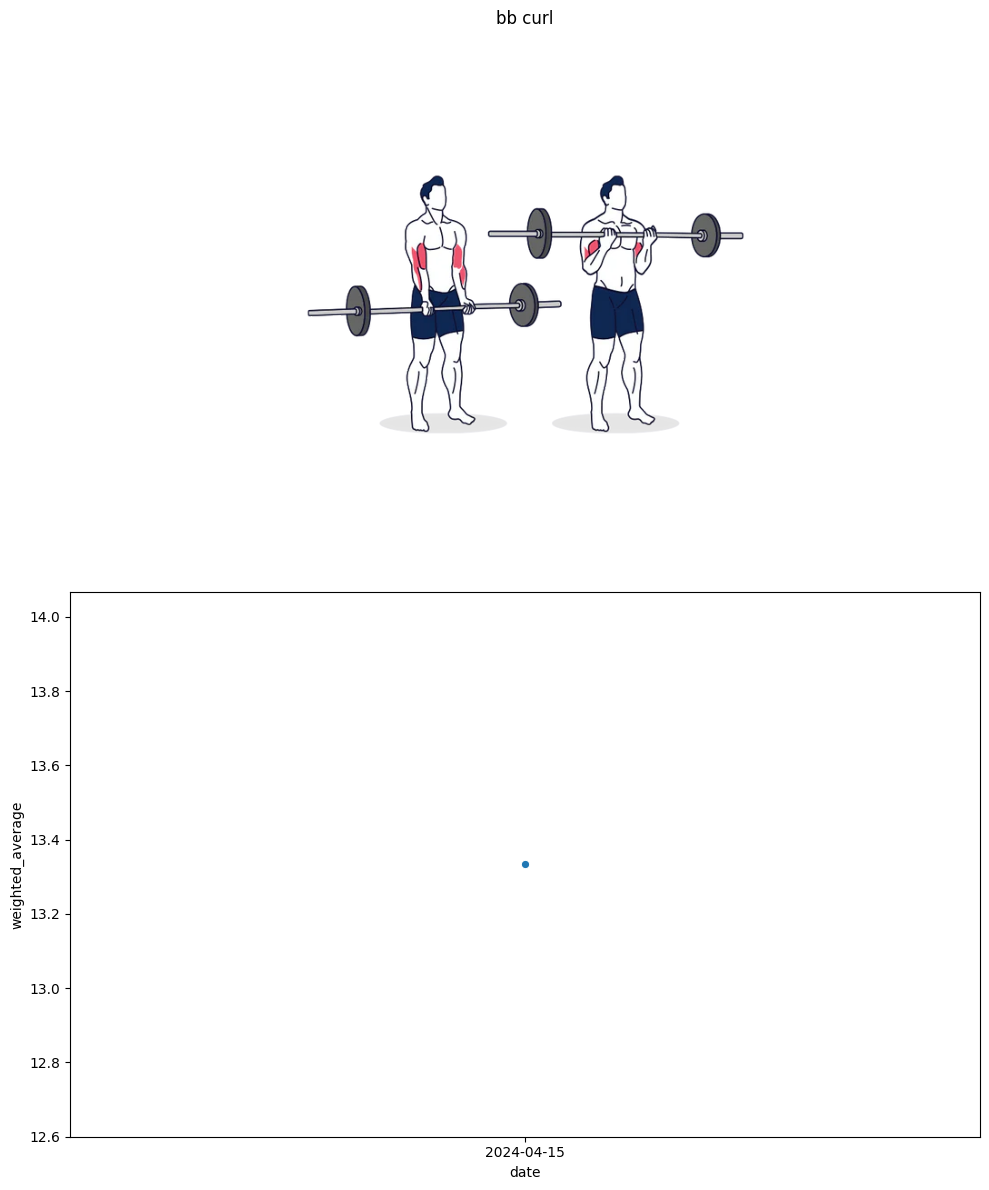

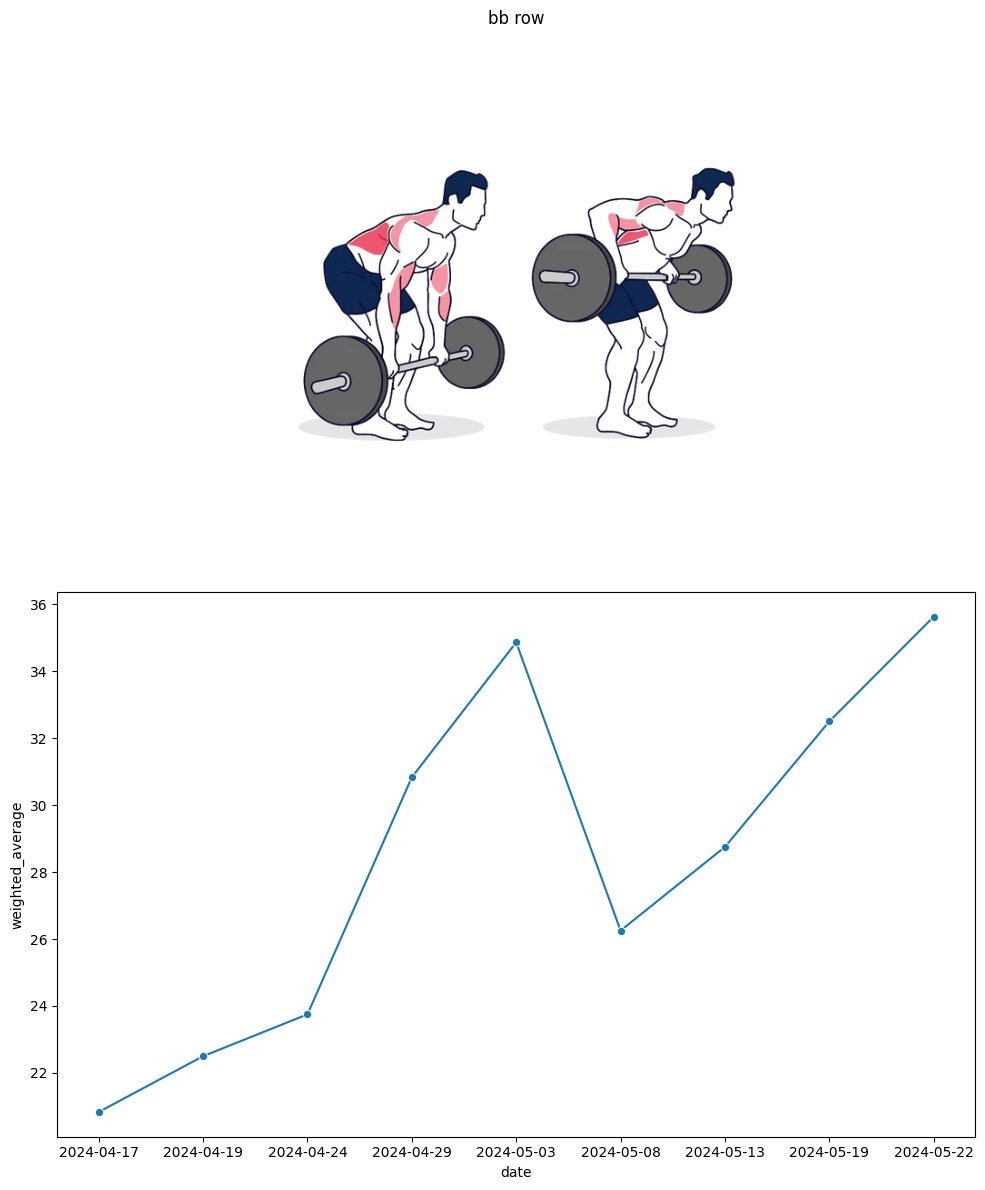

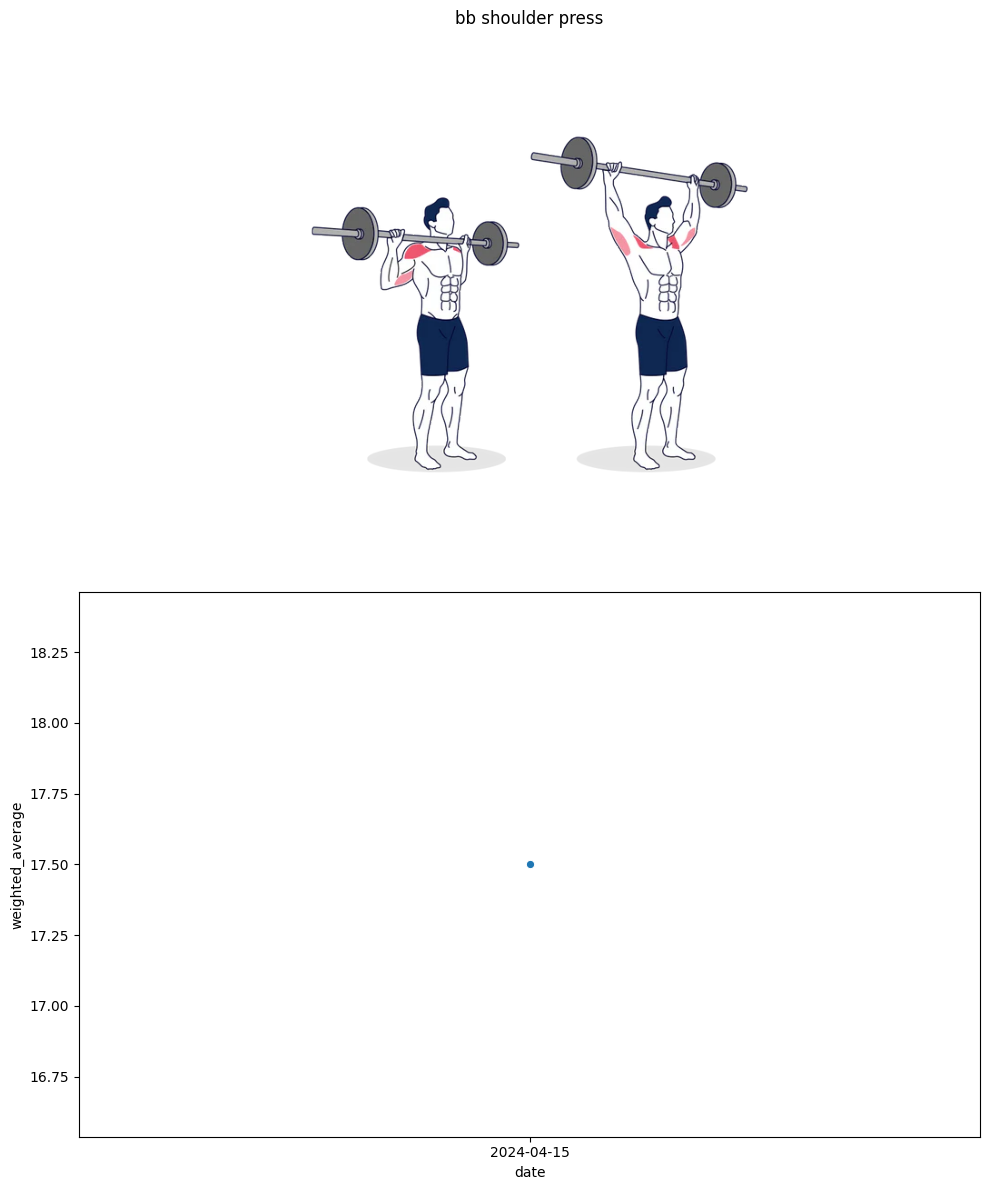

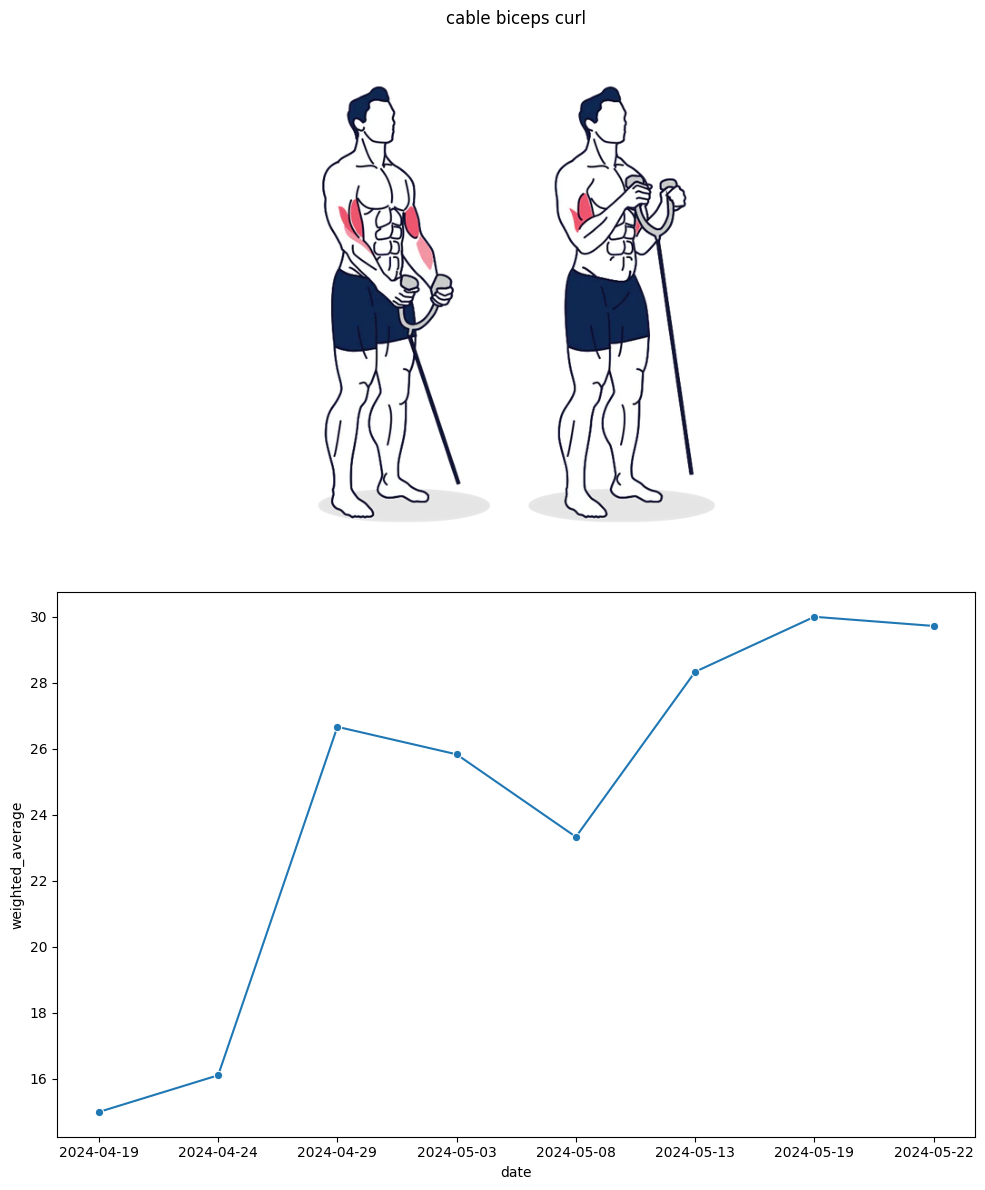

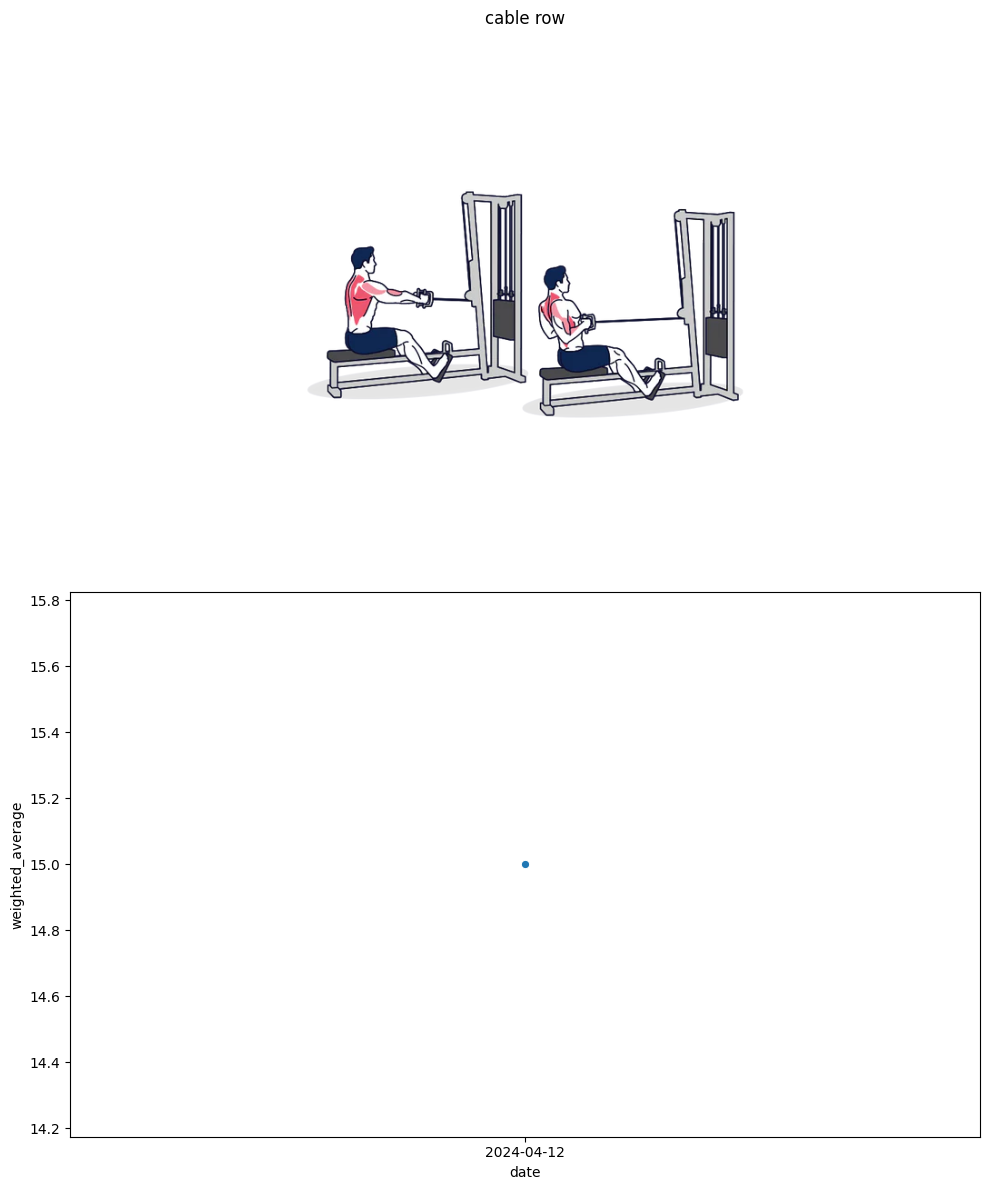

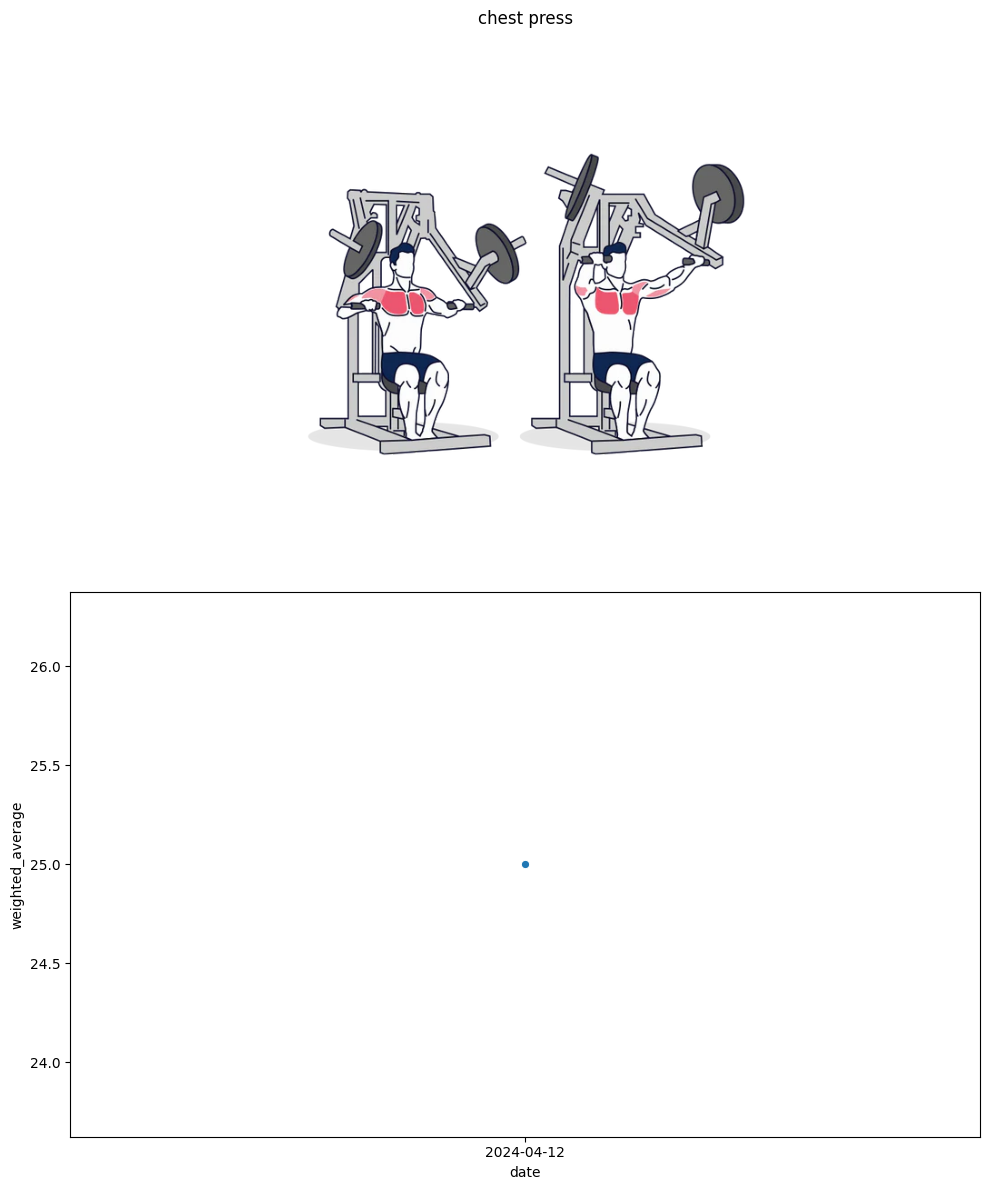

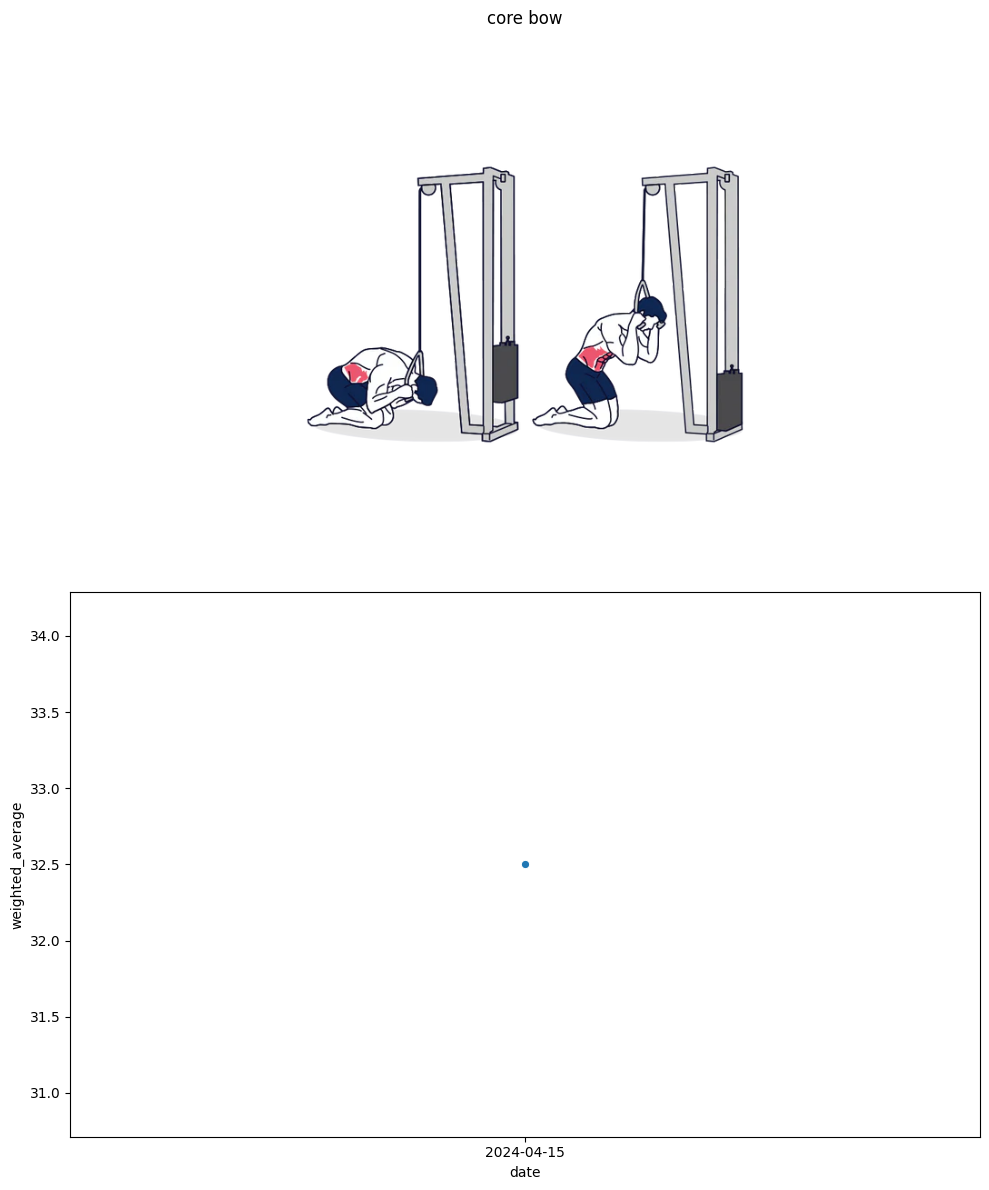

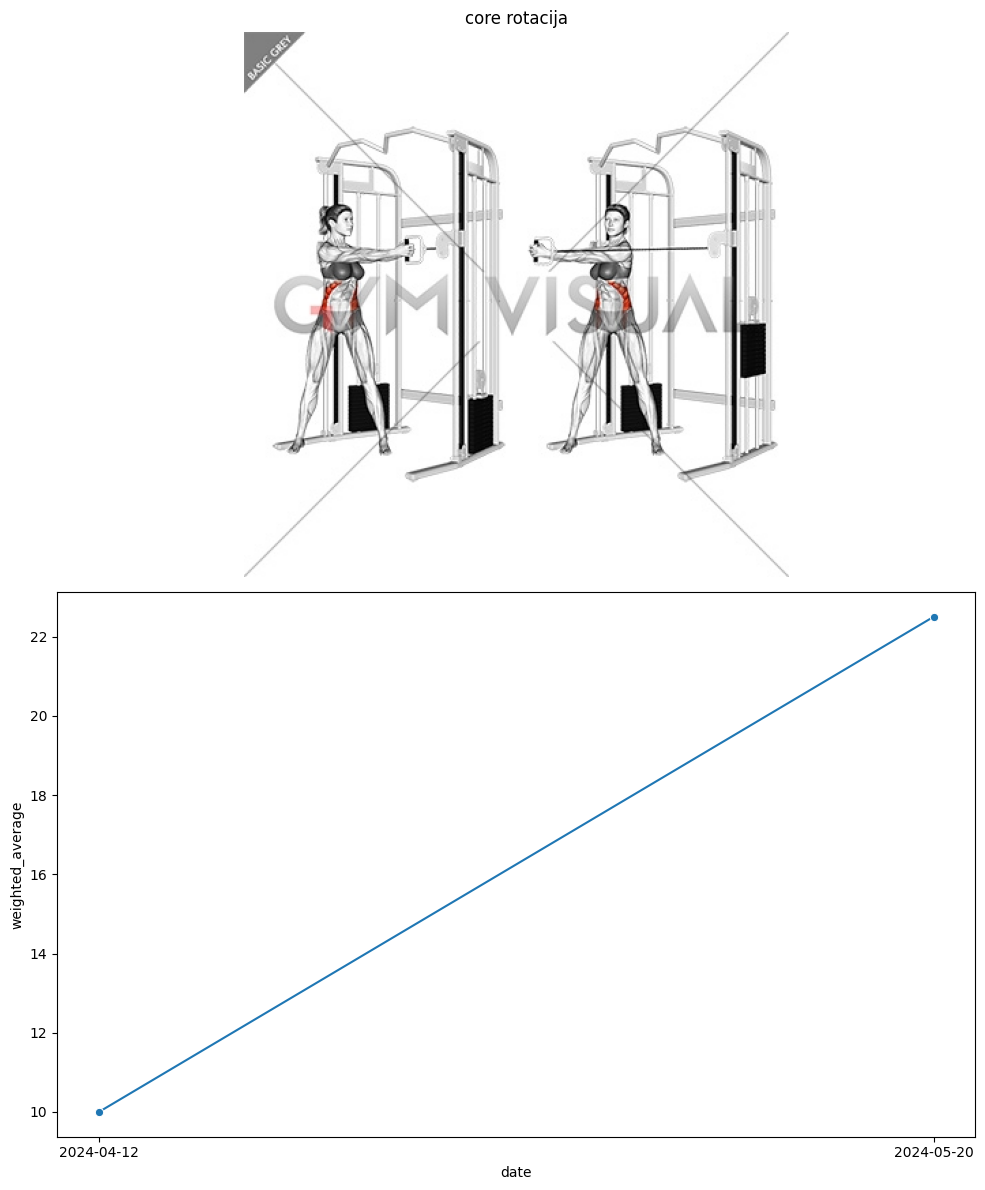

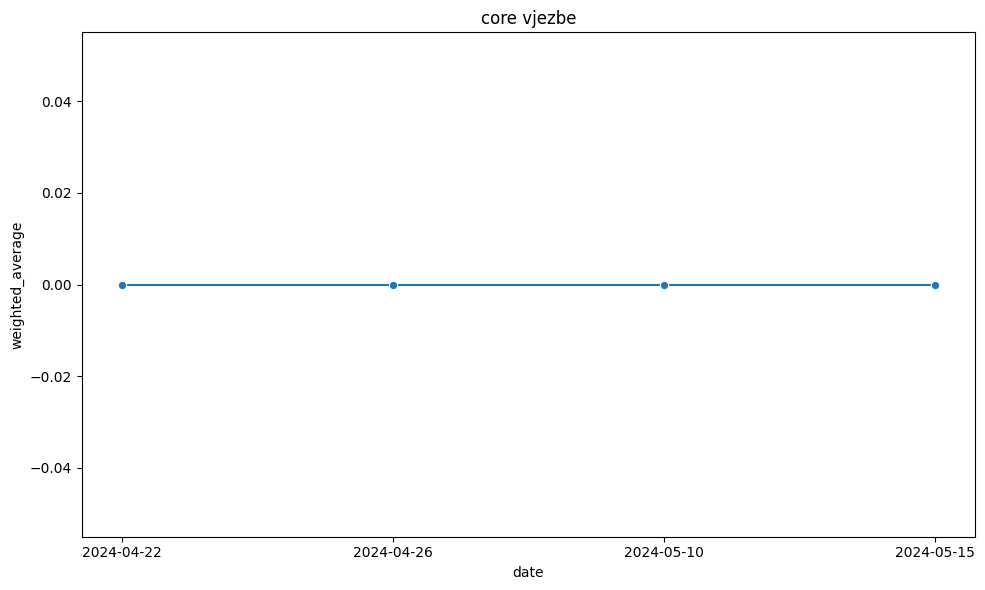

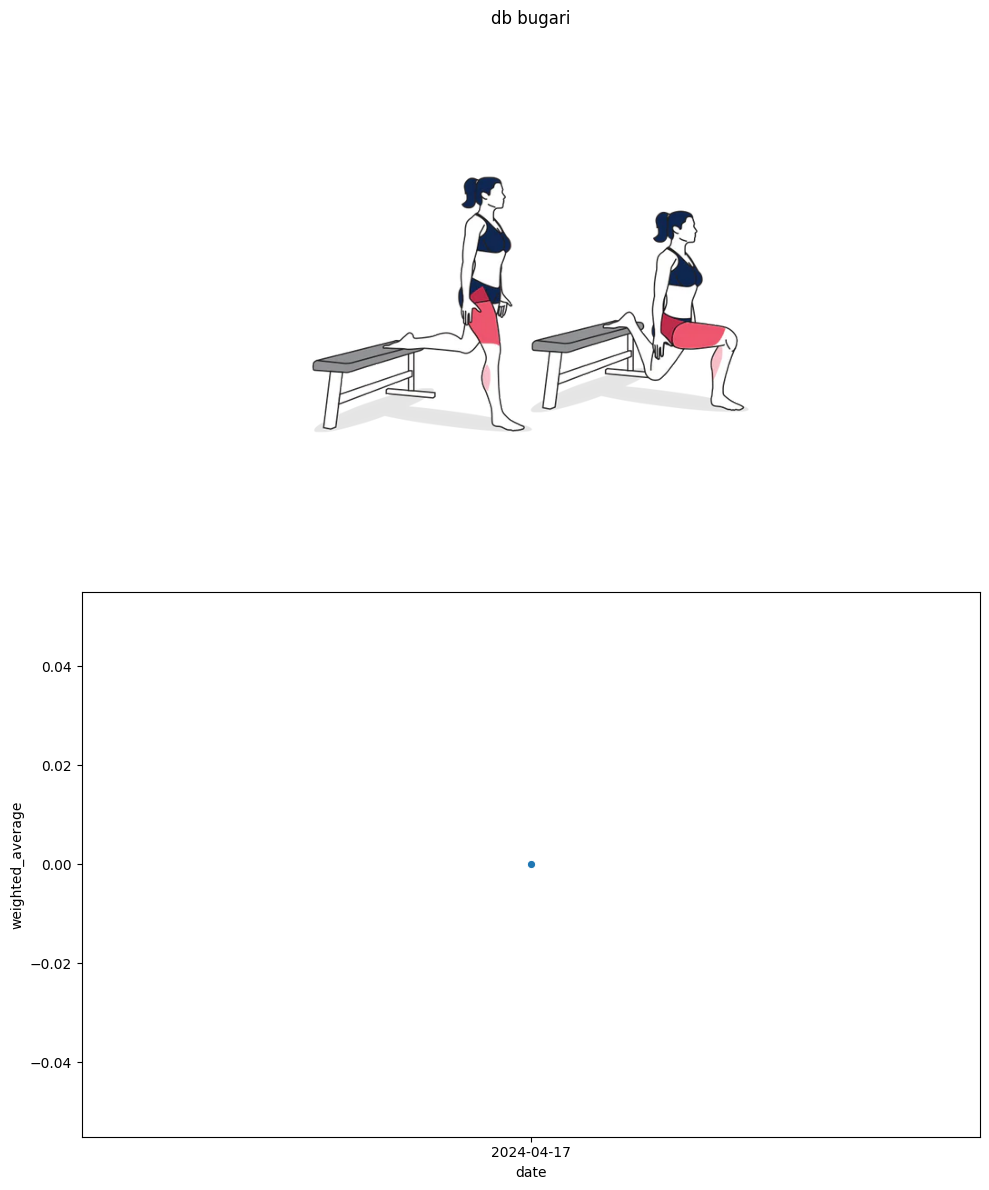

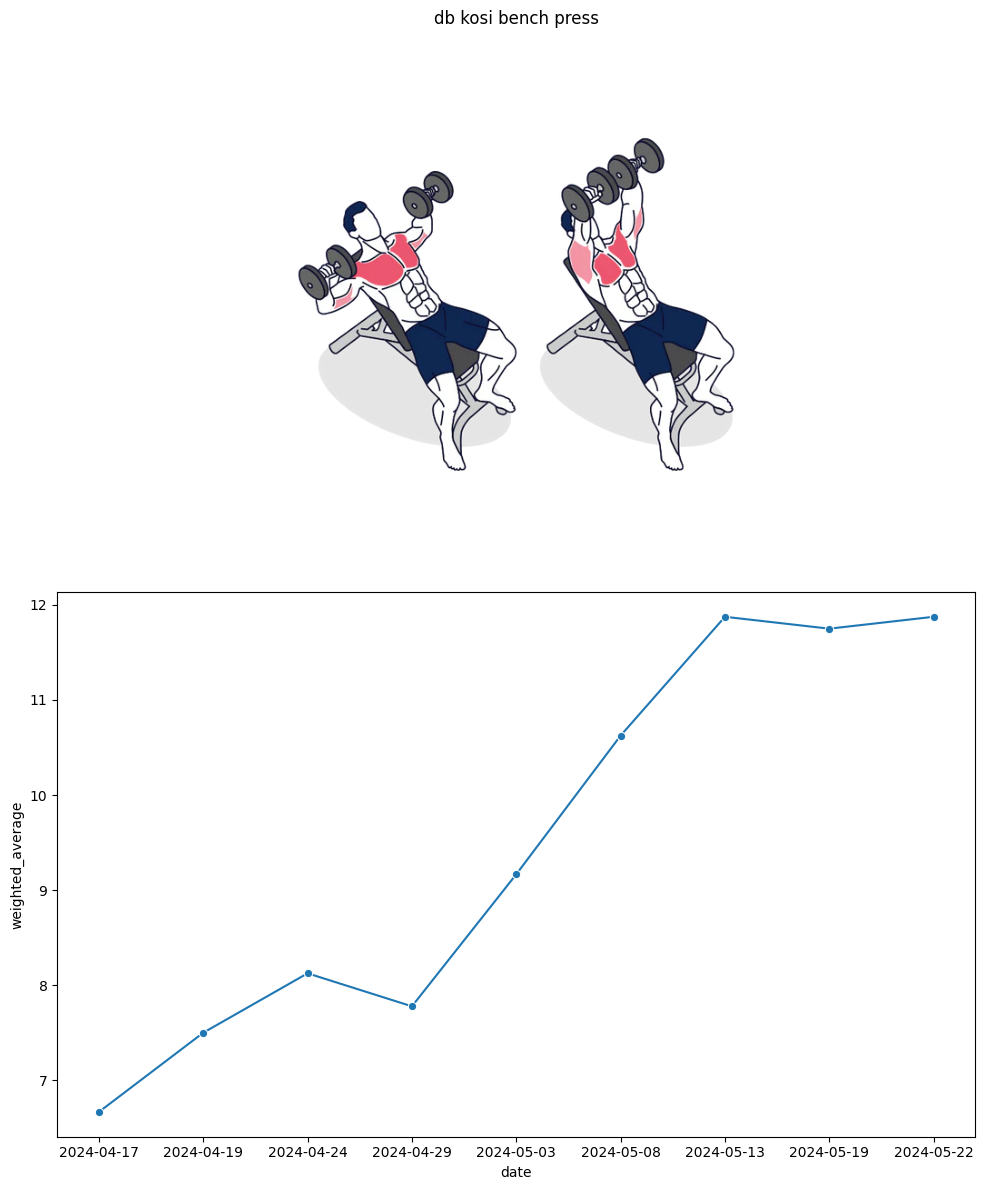

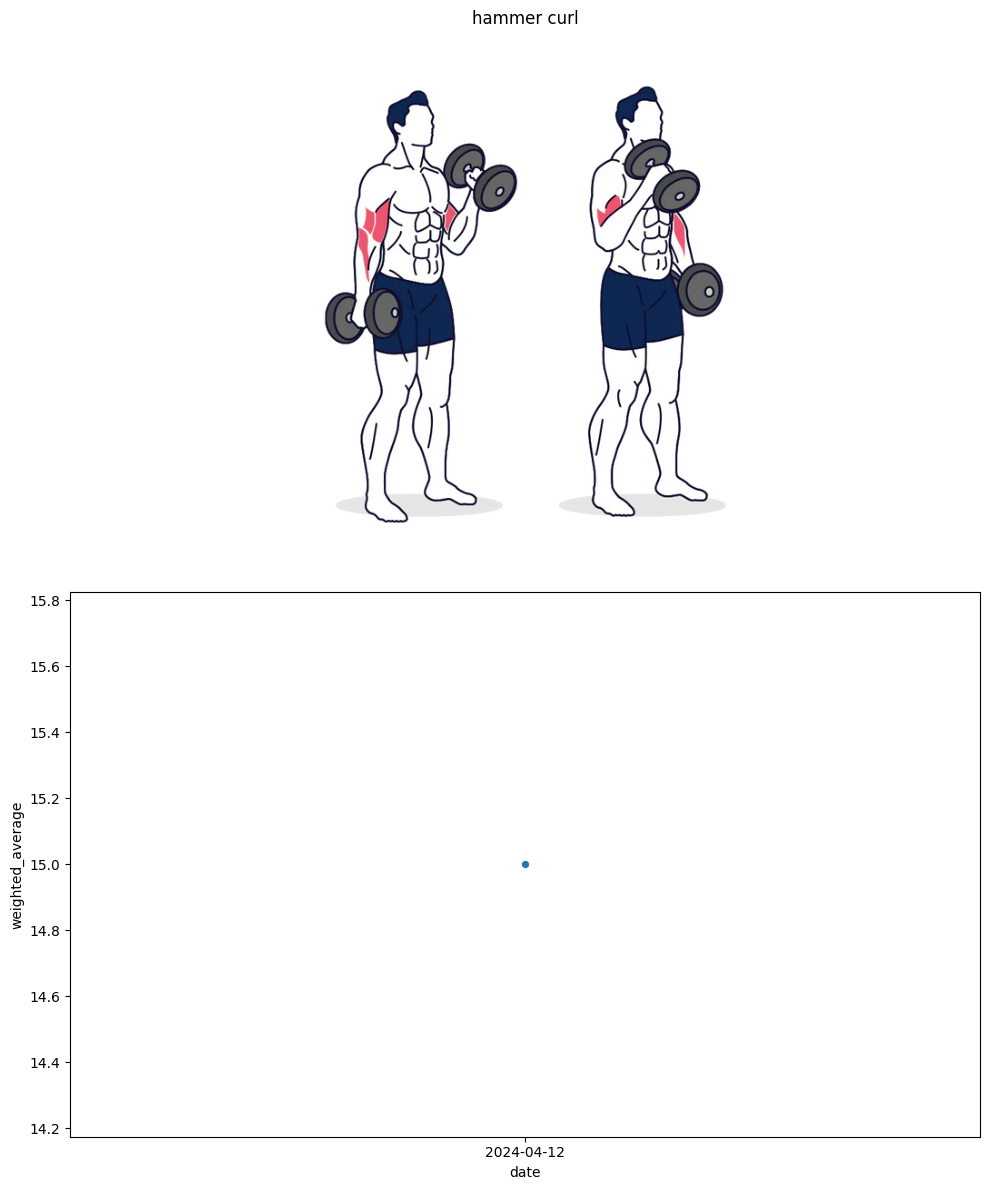

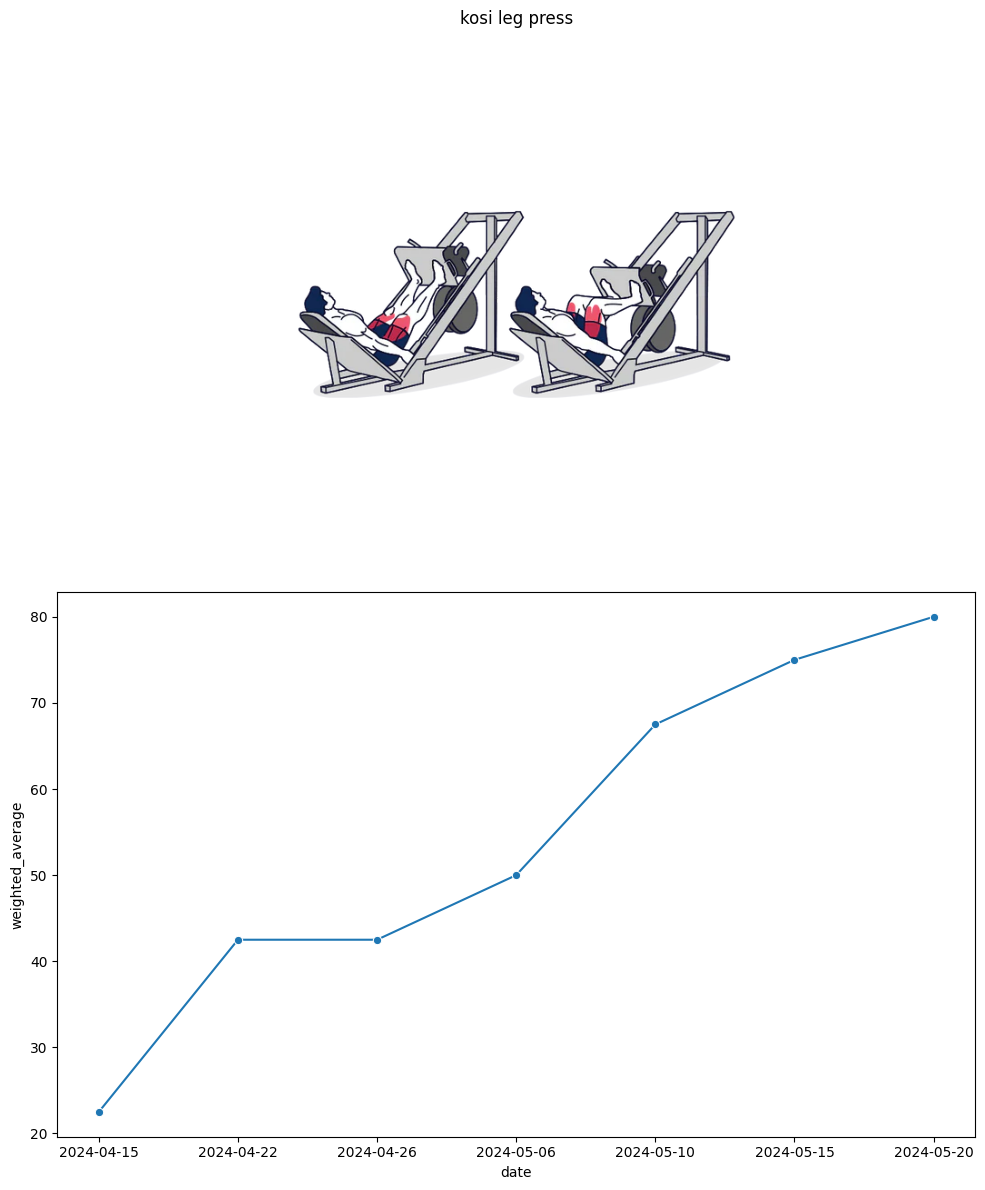

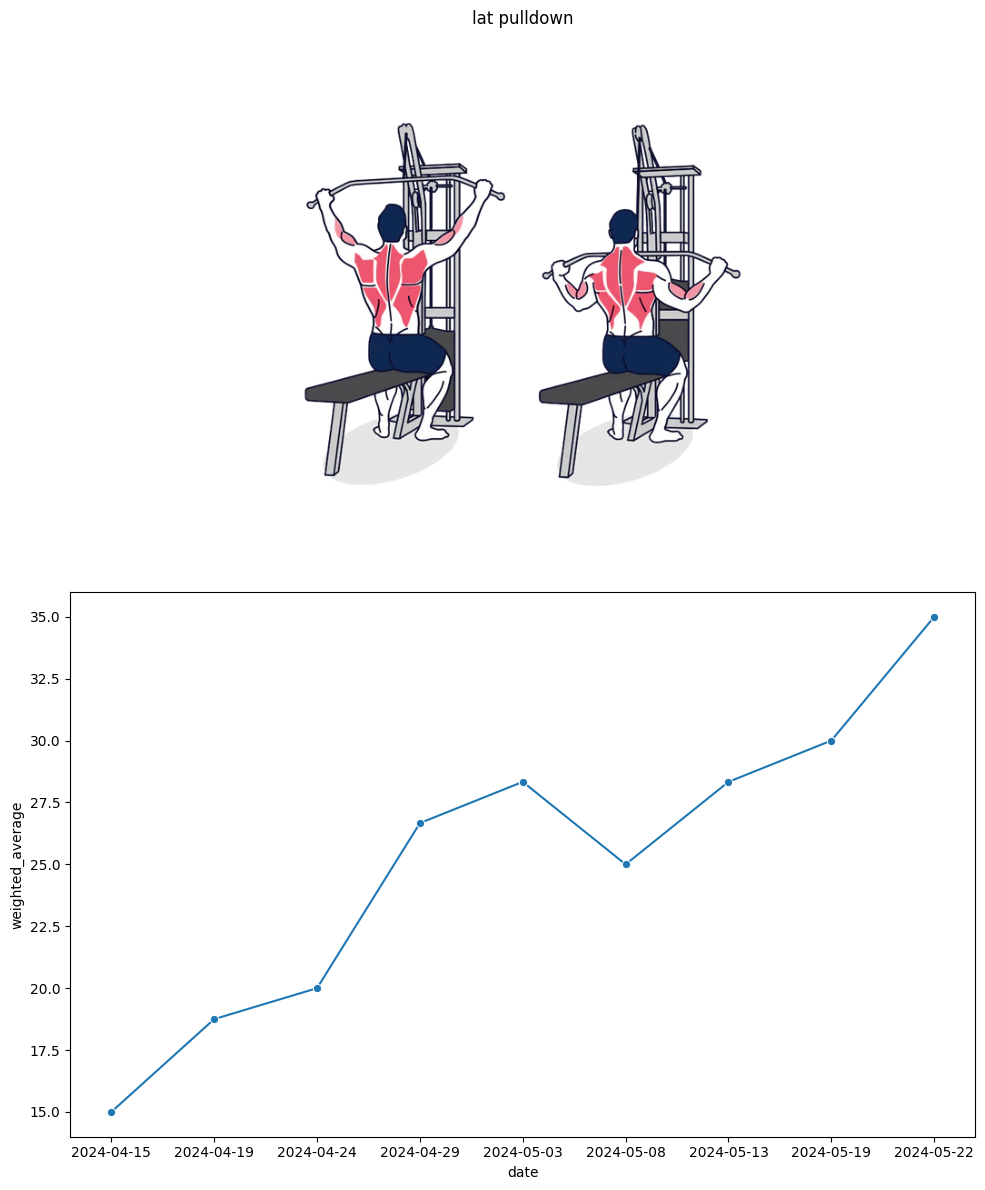

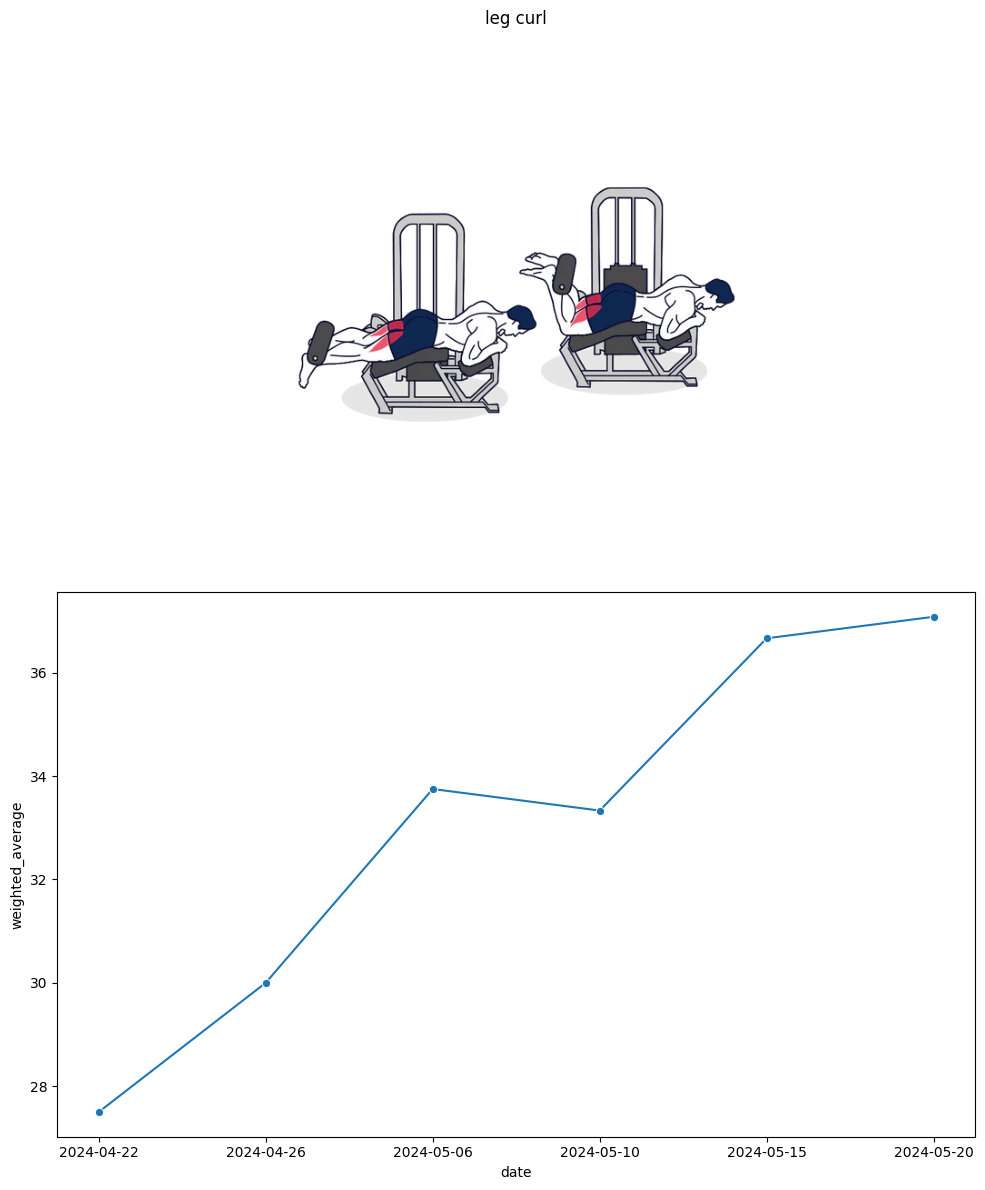

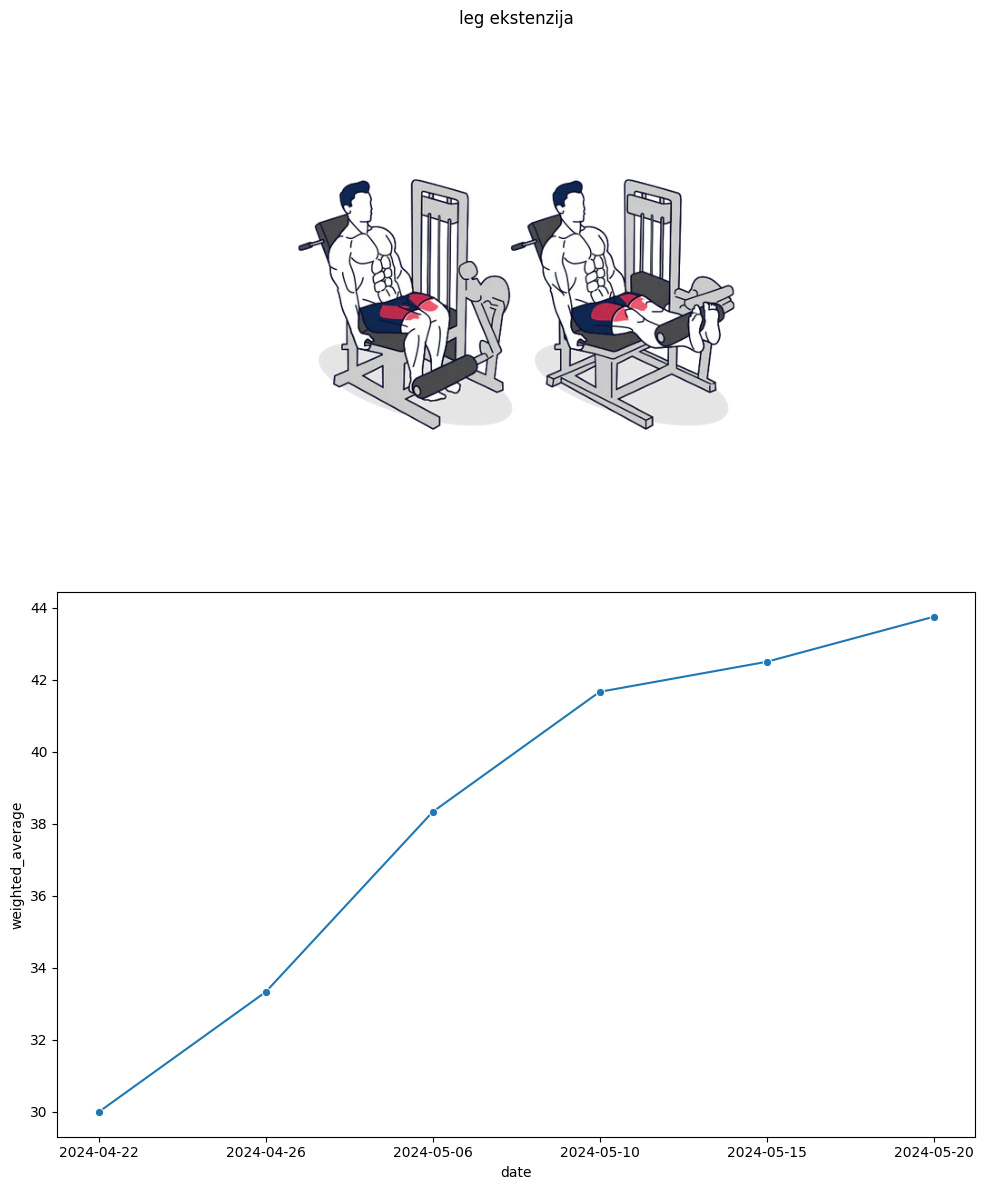

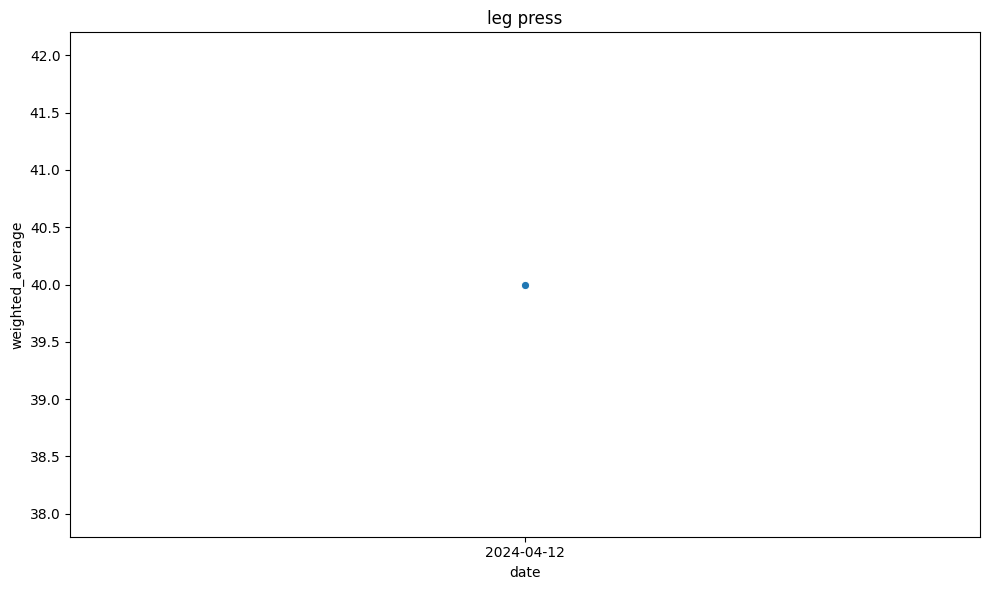

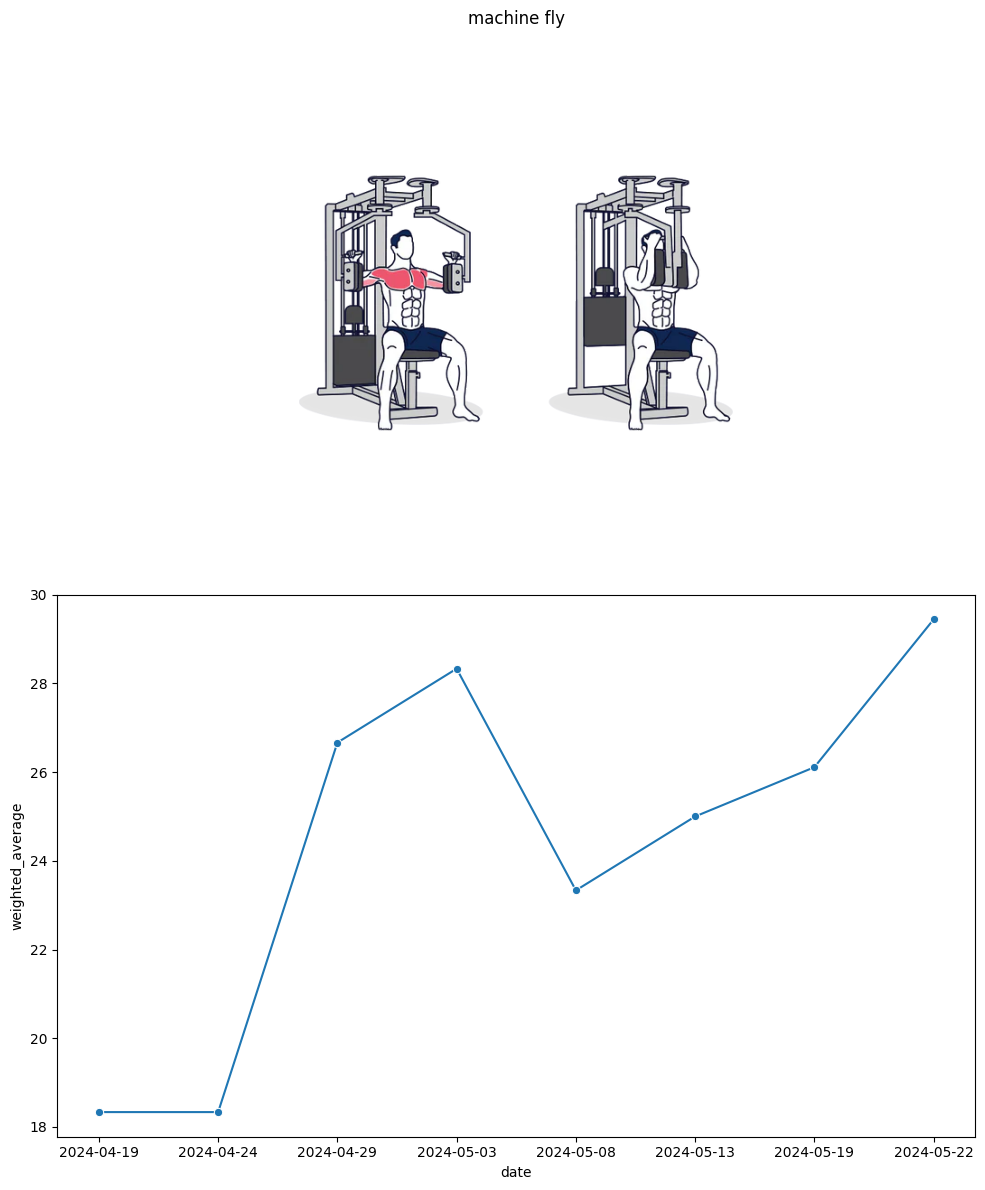

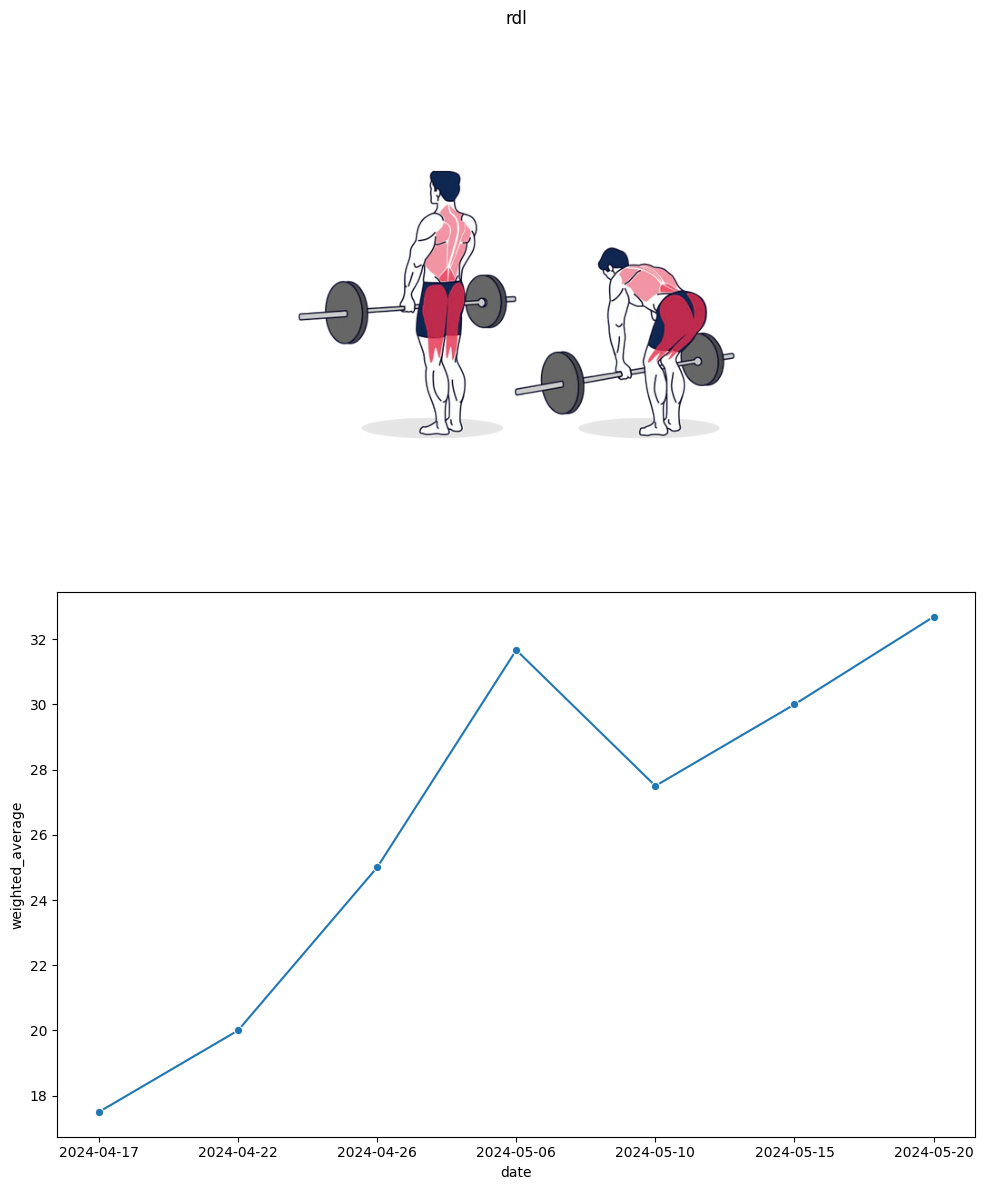

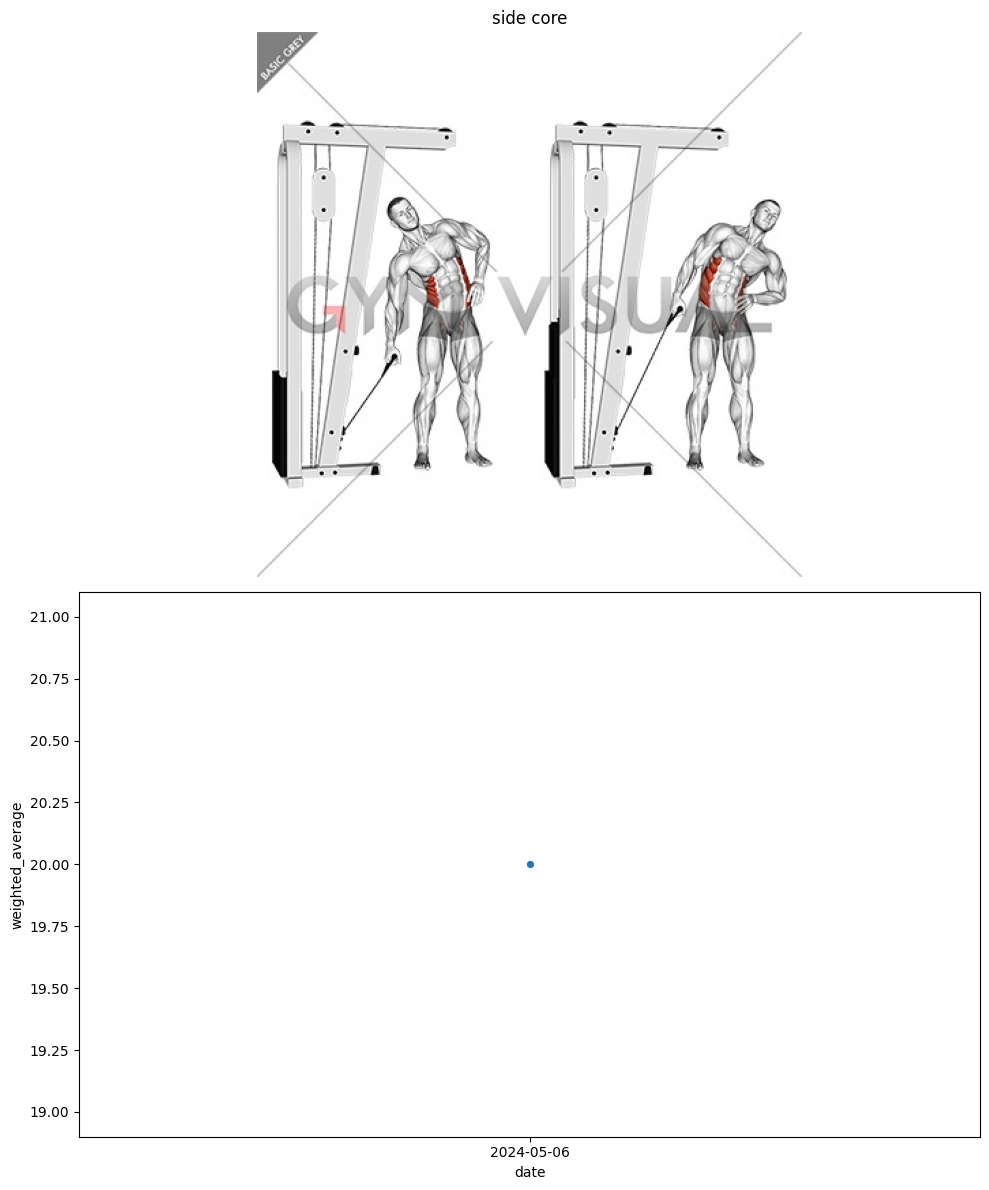

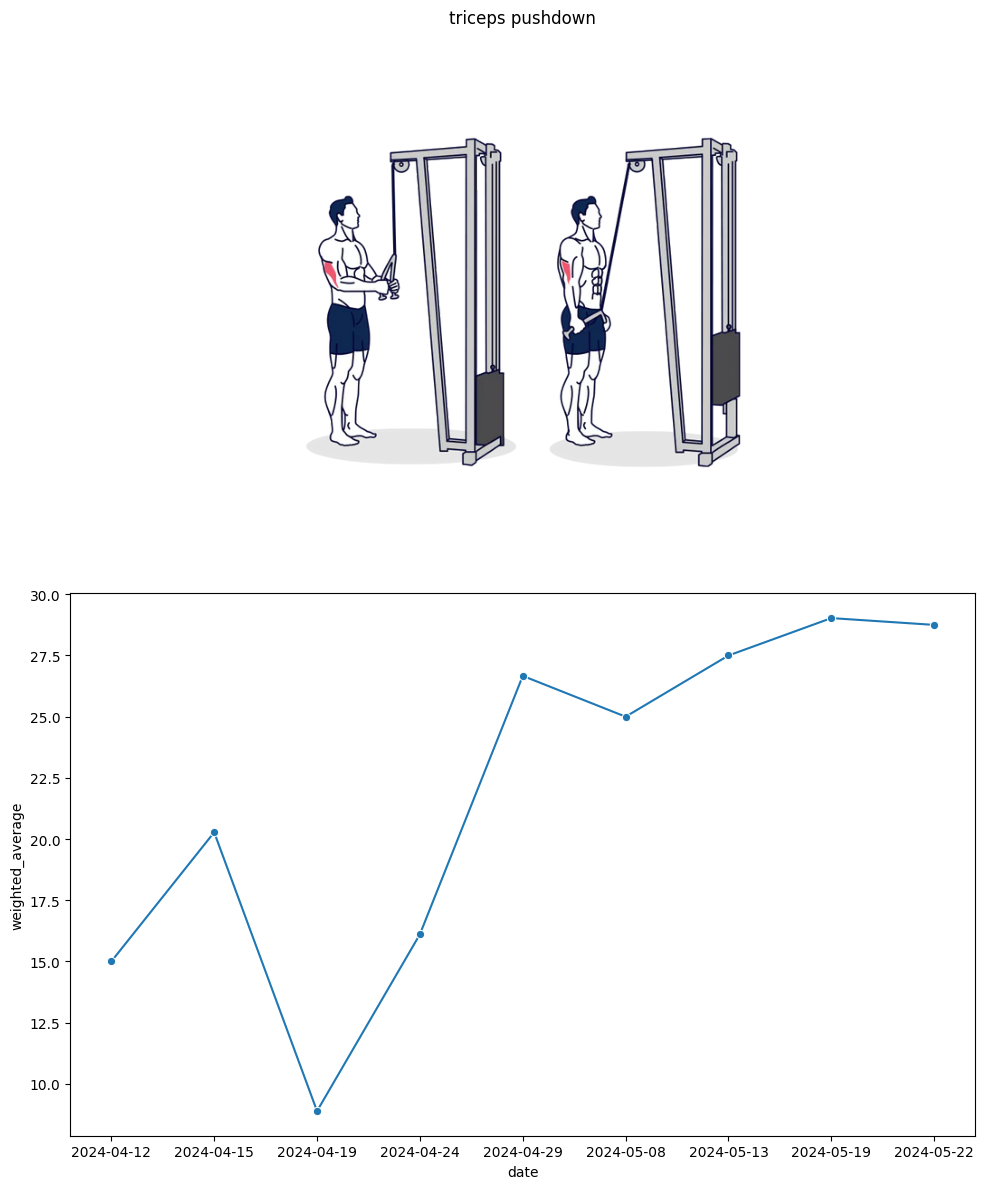

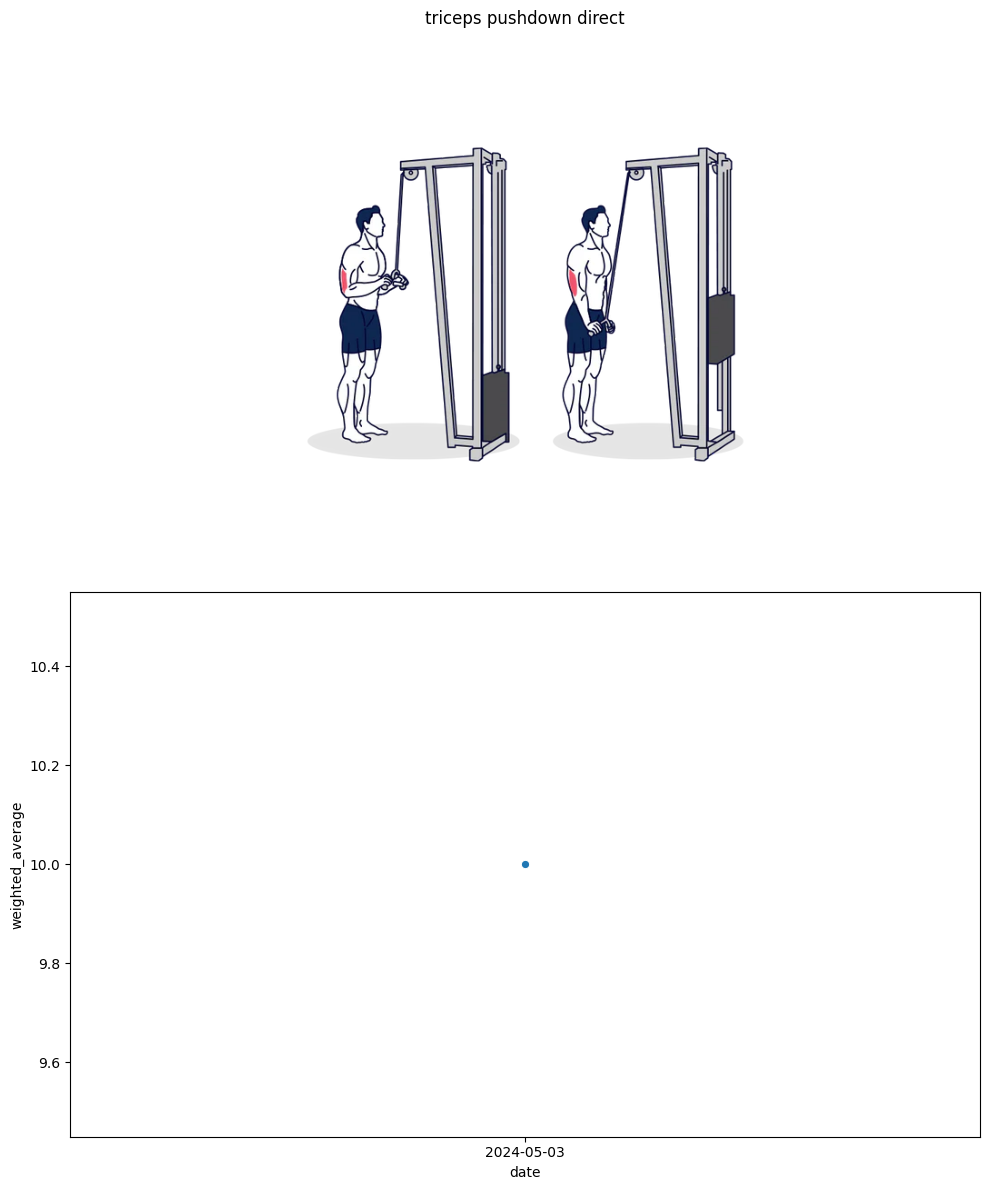

In [4]:
# Plot the average weight for each exercise
exercises = average_weights['exercise'].unique()
for exercise in exercises:
    exercise_data = average_weights[average_weights['exercise'] == exercise]

    # Check if the image file exists
    img_path = f'img/{exercise.replace(' ', '_')}.webp'  
    if not os.path.exists(img_path):
        img_path = f'img/{exercise.replace(' ', '_')}.jpg'
    if os.path.exists(img_path):
        # If the file exists, create 2 subplots and display the image
        fig, axs = plt.subplots(2, 1, figsize=(10, 12))

        img = imread(img_path)
        axs[0].imshow(img)
        axs[0].axis('off')  # hide the axis
        axs[0].set_title(exercise)

        sns.lineplot(x='date', y='weighted_average', data=exercise_data, 
                     marker='o', ax=axs[1])
    else:
        # If the file doesn't exist, create 1 subplot
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.lineplot(x='date', y='weighted_average', data=exercise_data, 
                     marker='o', ax=ax)
        ax.set_title(exercise)

    plt.tight_layout()
    plt.show()

## Grade training

The training is graded by calculating the training score. The training score 
uses the excercise score for each excercise that is done for that particular
training. The excercise score is calculated as a percentage of the average 
weight increase from the last time the same excercise was performed using the 
following formula:

$$
ES = 
\begin{cases}
  0 & \text{if } k \leq 1 \\
  100 \times (\frac{WEavg_k}{WEavg_{k-1}} - 1) & \text{otherwise}
\end{cases}
$$

Excercise score is calculated for each excercise for the training that has
non-zero average weight and non-zero previous average weight for the same 
excercise type.

where:
- $ES$ is the excercise score
- $WEavg_k$ is the average weight for the $k$-th excercise
- $WEavg_{k-1}$ is the average weight for the previous excercise of the same 
  type

The training score is calculated by averaging the excercise scores using 
the following formula:

$$
TS = \frac{\sum_{i=1}^{n} ES_i}{n}
$$

where:
- $TS$ is the training score
- $ES_i$ is the excercise score for the $i$-th excercise
- $n$ is the number of excercises in a training

The cumulative training score is calculated by summing the training scores for
each training using the following formula:

$$
CTS_j = CTS_{j-1} + TS_j
$$

$$
CTS_0 = 0
$$

where:
- $CTS_j$ is the cumulative training score for the $j$-th training
- $CTS_0$ is the initial cumulative training score

In [5]:
# Add previous weighted average of the same exercise
average_weights['previous_weighted_average'] = (
    average_weights.groupby('exercise')['weighted_average'].shift())

# Fill missing values with the current weighted average
average_weights['previous_weighted_average'] = (
    average_weights['previous_weighted_average'].fillna(
    average_weights['weighted_average']))

# Take only rows with non-zero values for both weighted_averages
average_weights = average_weights.loc[
    (average_weights['weighted_average'] != 0) 
    & (average_weights['previous_weighted_average'] != 0)]

# Calculate the training score for each exercise
average_weights['training_score'] = 100 * (
    average_weights['weighted_average'] 
    / average_weights['previous_weighted_average']
    - 1)

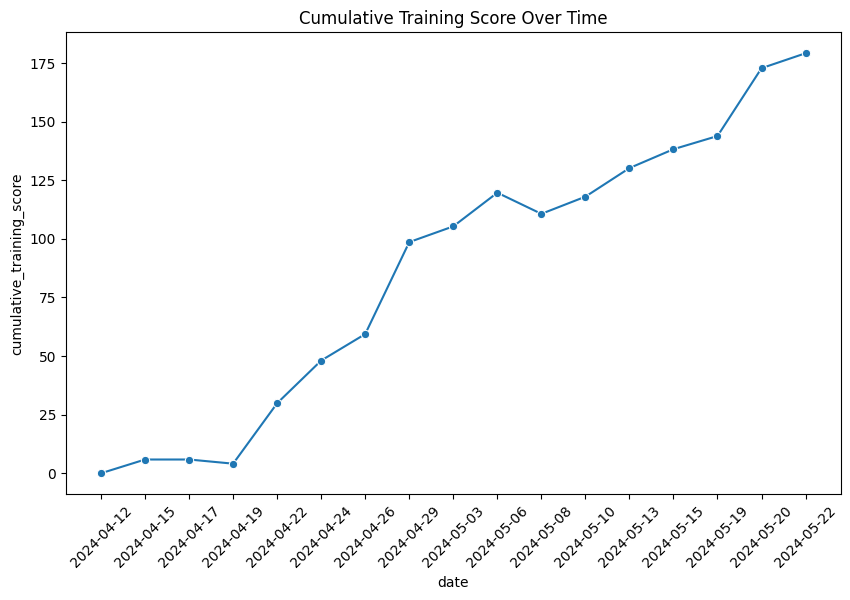

,date,training_score,cumulative_training_score
0,2024-04-12,0.000000,0.000000
1,2024-04-15,5.864198,5.864198
2,2024-04-17,0.000000,5.864198
3,2024-04-19,-1.777397,4.086800
4,2024-04-22,25.793651,29.880451
5,2024-04-24,18.202160,48.082612
6,2024-04-26,11.300505,59.383117
7,2024-04-29,39.228903,98.612020
8,2024-05-03,6.715868,105.327887
9,2024-05-06,14.362745,119.690632


In [6]:
# Calculate the average training score for each day
average_training_score = average_weights.groupby('date')[
    'training_score'].mean().reset_index()

# Calculate the cumulative training score over time
average_training_score['cumulative_training_score'] = (
    average_training_score['training_score'].cumsum())

# Plot the cumulative training score over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='cumulative_training_score', 
             data=average_training_score, marker='o')
plt.title('Cumulative Training Score Over Time')
plt.xticks(rotation=45)
plt.show()

average_training_score

## Training score by categories

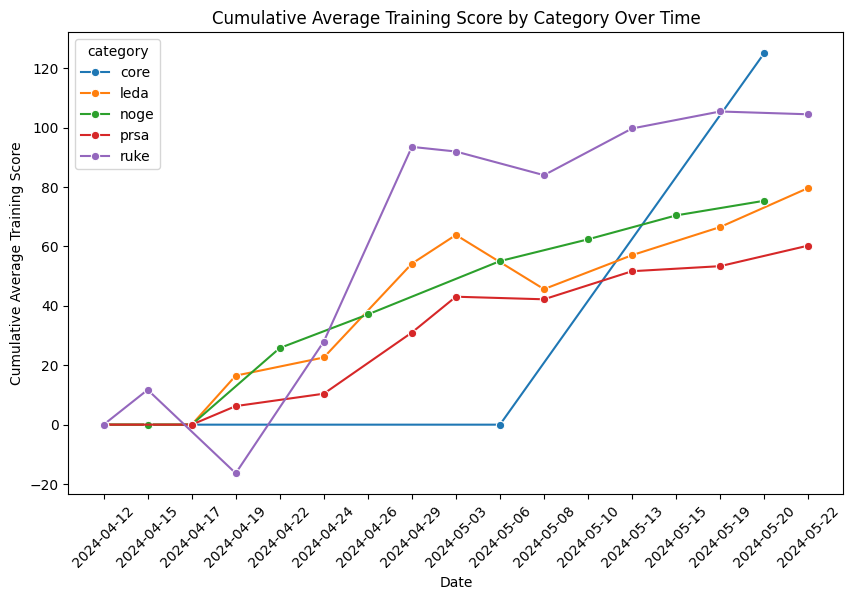

In [7]:
training_score_by_category = average_weights.groupby(['date', 'category'])[
    'training_score'].mean().reset_index()

# Calculate the cumulative training score over time
training_score_by_category['cumulative_training_score'] = (
    training_score_by_category.groupby('category')['training_score'].cumsum())

plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='cumulative_training_score', hue='category', 
             data=training_score_by_category, marker='o')
plt.title('Cumulative Average Training Score by Category Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Average Training Score')
plt.xticks(rotation=45)
plt.show()